In [21]:
import os
import requests

import gc
import pickle
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as preproc_scale
import plotly.express as px
%matplotlib inline
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from outlierutils import median_imputation, LabelSubmitter, plot_outlier_scores, plot_top_N, train_test_isoF

In [5]:
TRAIN_DATA_PATH = 'data/train.pkl'
TRAXCOLUMNS_PATH = 'data/trax_columns.pkl'
RAW_TRAX_DATA_PATH = 'data/train_transaction.csv'
RAW_ID_DATA_PATH = 'data/train_identity.csv'
LABEL_PATH = 'data/y_train.pkl'

### Load data

In [6]:
train = pd.read_pickle(TRAIN_DATA_PATH)
transaction_cols = pd.read_pickle(TRAXCOLUMNS_PATH) 

In [7]:
column_groups = {'card': [c for c in train.columns if c.startswith('card')],
                   'addr': [c for c in train.columns if c.startswith('addr')],
                   'dist1': ['dist1', 'dist2'],
                   'C' : [c for c in train.columns if c.startswith('C')],
                   'D' : [c for c in train.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in train.columns if c.startswith('M')],
                   'id' : [c for c in train.columns if c.startswith('id')],   
                   'V': [c for c in train.columns if c.startswith('V')],
                   'trans': [c for c in train.columns if c.startswith('Trans')]}


### Convert V-columns

In [8]:
V_original = median_imputation(train[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)

### Do outlier detection

In [9]:
isof = train_test_isoF(X_train=V_original, 
                       y_train=train.isFraud,
                      X_test=None, 
                      y_test=None)
scores = - isof.decision_function(V_original)

AUC Score on Train: 0.746


In [11]:
scores

array([-0.19758012, -0.19675832, -0.19817832, ..., -0.19876502,
       -0.19817832, -0.19301005])

In [56]:
# Make the list with predicted positives. Take the top-1000 in outlier score
N = 1000
top_N = np.argsort(scores)[::-1][:N]
top_N_scores = scores[top_N]

In [57]:
def plot_outlier_scores(scores, y_true):
    """
    To-Do: modify such that it can deal with the predictions from the API
    """
    roc_score = roc_auc_score(y_true, scores)
    classify_results = pd.DataFrame(data=pd.concat((y_true, pd.Series(scores)), axis=1))
    classify_results.rename(columns={0:'score'}, inplace=True)
    sns.kdeplot(classify_results.loc[classify_results.isFraud==0, 'score'], label='negatives', shade=True, bw=0.01)
    sns.kdeplot(classify_results.loc[classify_results.isFraud==1, 'score'], label='positives', shade=True, bw=0.01)
    plt.title('AUC: {:.3f}'.format(roc_score))
    plt.xlabel('Score');
    return classify_results

In [77]:
y_true = ls_remote.all_labels

In [82]:
y_true.head()

130     0.0
791     0.0
1325    0.0
1389    0.0
1823    0.0
dtype: float64

In [84]:
top_N

array([ 79711,  78861,  78870,  78607,  74386,  78915,  78951,  78875,
        78376,  78231,  78228,  78601,  78555,  78205,  79042,  78181,
        92484,  78860,  74381,  78176,  78172,  78590,  78852,  74278,
        95410,  92491,  92446, 198776, 198778, 198780,  74287, 198773,
       198772, 197536, 197521,  92425, 198771,  92437,  85249,  33956,
       197519,  78583,  92452,  94573,  35584,  94647,  78155,  79694,
       197502, 197503, 198769, 198768,  19491, 137916,  74415,  35591,
        81959,  81961,  78150,  78154, 197487,  78733, 100776, 147773,
        79002,  86643,  95383,  31147,  94587, 151149,  74400, 131273,
        94561, 135644, 197476, 197467, 100753,  92423,  92493,  96801,
        81957,  94685, 100781,  77711, 147727, 127441,  26386, 100743,
       137915,  74104, 100920, 198790, 100739, 136232,  89650,  19487,
       113255,  78656, 151145,  79313,  26423,  77897,  94664,  89579,
        89560,  94635, 131195, 131266,  94668, 151141,  78144,  94862,
      

In [79]:
classify_results = pd.DataFrame(data=pd.concat((y_true, pd.Series(scores)), axis=1))

In [80]:
classify_results

,0,1
0,NaN,-0.197580
1,NaN,-0.196758
2,NaN,-0.198178
3,NaN,-0.145993
4,NaN,-0.172200
5,NaN,-0.198178
6,NaN,-0.198178
7,NaN,-0.196758
8,NaN,-0.172200
9,NaN,-0.195219


### Submit to API

In [71]:
ls_remote = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url="https://unsupervised-label-api.herokuapp.com/")
ls_remote.get_jwt_token()

In [72]:
response = ls_remote.post_predictions(top_N)

submitted 1000 new points
number of positives in submission: 237
precision of submission: 23.70%


,N_positives_found,N_submitted,precision
admin,0.0,21.0,0.000000
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
test,229.0,10050.0,2.278607
ernst,237.0,1000.0,23.700000


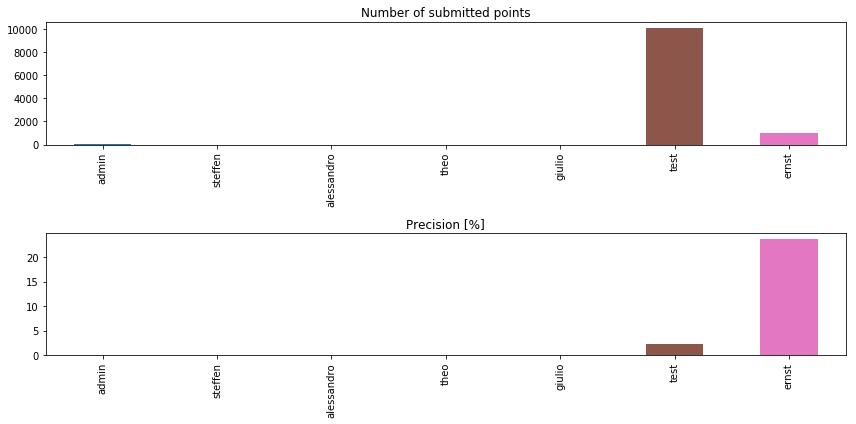

In [73]:
ls_remote.get_statistics()

In [76]:
ls_remote.get_labels()

number of predictions made: 1000
total number of positives found: 237
total precision: 23.70%
